<a href="https://colab.research.google.com/github/u-masao/vital_statistics_jp/blob/main/notebooks/02_time_series_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install package

In [1]:
!pip install vital-statistics-jp

## Read data

Read monthly prompt data of vital statistics from "Ministry of Health" in japan.

https://www.mhlw.go.jp/toukei/list/81-1a.html

In [2]:
from vital_statistics_jp import read_prompt

stat_df = read_prompt()

print(stat_df)

         category         ts  value
0     live births 2005-01-01  95817
1     live births 2005-02-01  83516
2     live births 2005-03-01  90745
3     live births 2005-04-01  88001
4     live births 2005-05-01  90143
...           ...        ...    ...
1231     divorces 2021-10-01  14405
1232     divorces 2021-11-01  15064
1233     divorces 2021-12-01  16471
1234     divorces 2022-01-01  14386
1235     divorces 2022-02-01  14051

[1236 rows x 3 columns]


In [3]:
print(stat_df.category.unique())

['live births' 'marriages' 'deaths' 'foetal deaths' 'natural change'
 'divorces']


## Plot data

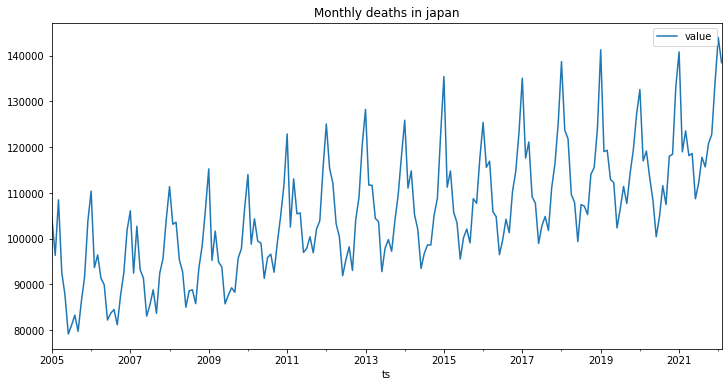

In [4]:
deaths_sr = stat_df.loc[stat_df.category=='deaths',['ts','value']].set_index('ts').astype(float)
deaths_sr.index.freq='MS'
deaths_sr.plot(title='Monthly deaths in japan', figsize=(12,6))

## Time series analysis

In [5]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

alpha=0.01

uc_model = sm.tsa.UnobservedComponents(
    np.log10(deaths_sr),
    level='local linear trend',
    freq_seasonal=[{'period':12, 'harmonics':6}],
)

uc_model.initial_variance = np.log10(deaths_sr).std().pow(2)*10e6
print('initial variance:', uc_model.initial_variance)
uc_result = uc_model.fit()
predict = 10**uc_result.get_prediction(start='2010-01-01', end='2023-08-01', alpha=alpha).summary_frame()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


initial variance: value    29139.151152
dtype: float64


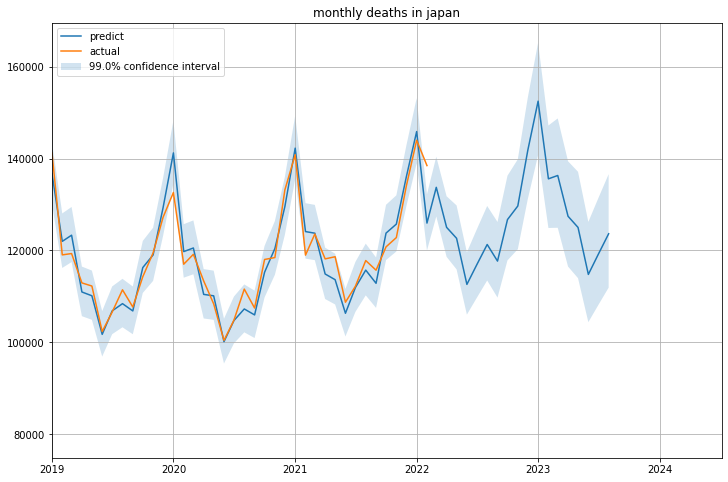

In [6]:
import datetime

fig, ax = plt.subplots(figsize=(12,8))
ax.fill_between(
    predict.index, 
    predict['mean_ci_lower'], 
    predict['mean_ci_upper'], 
    alpha=0.2, 
    label=f'{(1-alpha)*100:0.1f}% confidence interval')
ax.plot(predict['mean'], label='predict')
ax.plot(deaths_sr, label="actual")

ax.legend(loc='upper left')
ax.grid()
ax.set_title('monthly deaths in japan')
ax.set_xlim(datetime.datetime(2019,1,1), None)
plt.show()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/structural.py:1661: RuntimeWarning: invalid value encountered in sqrt
  std_errors = np.sqrt(component_bunch['%s_cov' % which])
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/structural.py:1661: RuntimeWarning: invalid value encountered in sqrt
  std_errors = np.sqrt(component_bunch['%s_cov' % which])
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/structural.py:1661: RuntimeWarning: invalid value encountered in sqrt
  std_errors = np.sqrt(component_bunch['%s_cov' % which])


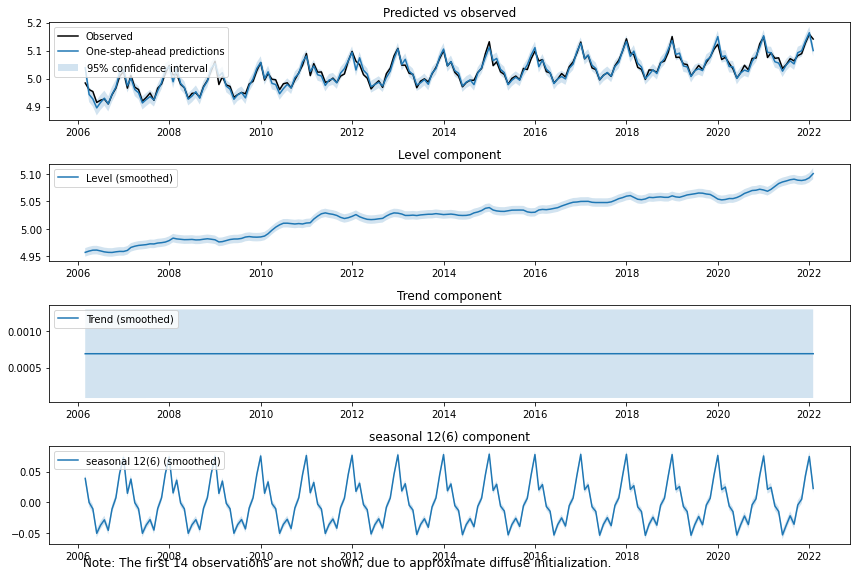

In [7]:
fig = plt.figure(figsize=(12,8))
uc_result.plot_components(fig=fig, legend_loc='upper left')
fig.tight_layout()
plt.show()

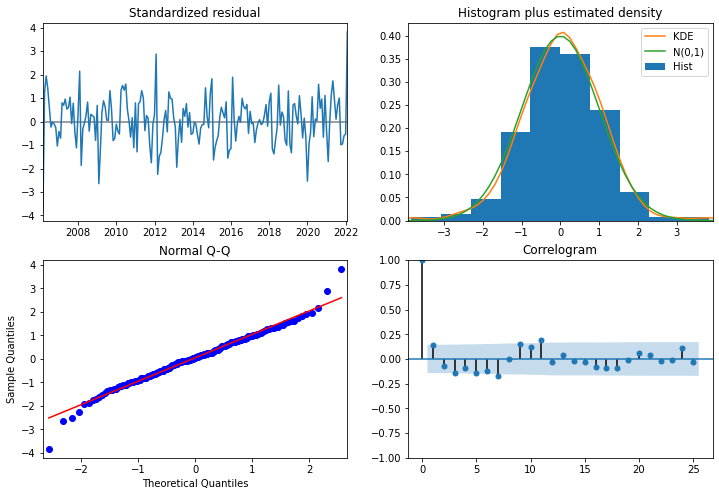

In [8]:
fig = plt.figure(figsize=(12,8))
uc_result.plot_diagnostics(fig=fig, lags=25)
plt.show()

In [9]:
uc_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                Unobserved Components Results                                
=============================================================================================
Dep. Variable:                                 value   No. Observations:                  206
Model:                            local linear trend   Log Likelihood                 591.598
                   + stochastic freq_seasonal(12(6))   AIC                          -1175.197
Date:                               Thu, 05 May 2022   BIC                          -1162.167
Time:                                       08:53:39   HQIC                         -1169.920
Sample:                                   01-01-2005                                         
                                        - 02-01-2022                                         
Covariance Type:                                 opg                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
sigma2.irregular            4.912e-05   7.09e-06      6.927      0.000    3.52e-05     6.3e-05
sigma2.level                1.948e-05   6.86e-06      2.840      0.005    6.03e-06    3.29e-05
sigma2.trend                4.861e-12   2.11e-08      0.000      1.000   -4.14e-08    4.14e-08
sigma2.freq_seasonal_12(6)  5.501e-08   3.73e-08      1.476      0.140   -1.81e-08    1.28e-07
===================================================================================
Ljung-Box (Q):                       56.09   Jarque-Bera (JB):                18.73
Prob(Q):                              0.05   Prob(JB):                         0.00
Heteroskedasticity (H):               0.87   Skew:                            -0.11
Prob(H) (two-sided):                  0.59   Kurtosis:                         4.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""